In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib.gridspec import GridSpec

from mtj.calc_Heff import calc_Heff
from mtj.calc_Hth import compute_thermal_field
from mtj.init import init_m
from mtj.llg_heun import LLG_Heun
from mtj.constants import VACUUM_PERMEABILITY

### Comparison between constant field approximation and recomputation in the Heun intermeiate step

The same simulations on a thin film of soft magnetic material (Permalloy) are performed with and without intermediate recomputation of the total magnetic field in the intermediate step in the Heun method. Thermal fluctuations are considered, but STT effect is not included. No external magnetic field is applied here and an arbitrary initial magnetization is chosen.

**Physical Constants Used**

| Constant | Symbol | Value | Unit | Description |
|----------|--------|-------|------|-------------|
| Saturation magnetization (Permalloy) | $m_S$ | $\approx 1$ | T | Typical for Permalloy |
| Magnetocrystalline anisotropy constant | $K_u$ | $5 \cdot 10^5$ | J/m³ | Example value for perpendicular anisotropy |
| Temperature | $T$ | 300 | K | Room temperature |
| Volume (approx.) | $V$ | $2000$, $300$, $80$ | nm³ | Magnetic sample volume |
| Time step | $\Delta t$ | $10^{-13}$ to $10^{-10}$ | s | Simulation time step |
| Damping factor | $\alpha$ | 0.008 | (unitless) | Gilbert damping parameter |

In [5]:
def calculate_magnetization(
    m0: npt.NDArray[
        np.float64
    ],  # Initial magnetization (is normalized before simulation)
    H_app: npt.NDArray[np.float64],
    Tn=1e-10,  # (s)
    dt=1e-13,  # time step (s)
    alpha=0.008,  # Damping factor (arbitrarily chosen in this demo)
    K_u=5e5,
    M_s=1 / VACUUM_PERMEABILITY,  # Default: NiFe permalloy Ms (A/m)
    u_k=np.array([0, 0, 1]),  # Shape anisotropy
    N=np.diag([0, 0, 1]),  # Default: "infinite" thin film
    T=300,  # Temperature (K) - H_th diabled if 0
    Vol=1e-9 * 25e-9**2 * np.pi,  # Volume
    Volt=0,  # STT voltage
    p=np.array([1, 0, 0]),  # STT polarizer orientation
    a_par=0,  # STT coefficients
    a_perp=0,
    stt_enable=False,
    recompute_H_th=False,
    recompute_H_eff=False
):
    time_series = np.arange(0, Tn, dt)
    m = init_m(m0, len(time_series))
    params = {
           "K_u": K_u,
            "M_s": M_s,
            "u_k": u_k,
            "p": p,
            "a_para": a_par,
            "a_ortho": a_perp,
            "V": Volt,
            "H_app": H_app,
            "N": N}

    for i, t in enumerate(time_series[:-1]):

        # Calculate the magnetization for the next time step
        m[i + 1] = LLG_Heun(m[i],
            params,
            T,
            Vol,
            dt,
            alpha,
            stt_enable=stt_enable,
            recompute_H_th=recompute_H_th,
            recompute_H_eff=recompute_H_eff)

    return m, time_series

In [6]:
timeFormatter = EngFormatter(unit="s")

1) No recomputation.

C:\Users\pietr\AppData\Local\Temp\ipykernel_1344\1435607134.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


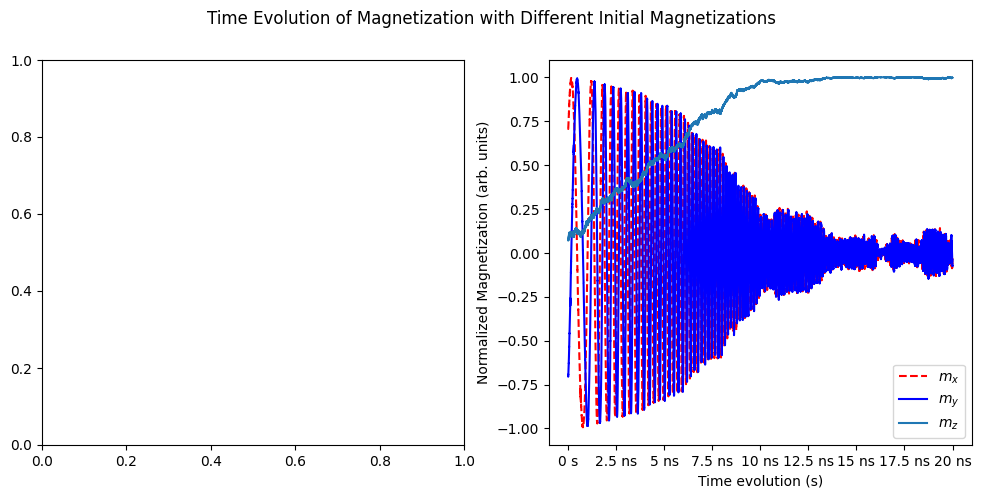

In [10]:
m, t = calculate_magnetization(m0=np.array([1, -1, 0.1]), H_app=np.zeros(3), Tn=20e-9)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[1].plot(t, m[:, 0], "r--", label=r"$m_x$")
ax[1].plot(t, m[:, 1], "b", label=r"$m_y$")
ax[1].plot(t, m[:, 2], label=r"$m_z$")

ax[1].xaxis.set_major_formatter(timeFormatter)
ax[1].set_xlabel("Time evolution (s)")
ax[1].set_ylabel("Normalized Magnetization (arb. units)")
ax[1].legend()
fig.suptitle("Time Evolution of Magnetization with Different Initial Magnetizations")

fig.show()

2) Recomputing only the thermal field.

In [9]:
m, t = calculate_magnetization(m0=np.array([1, -1, 0.1]), H_app=np.zeros(3), Tn=20e-9, recompute_H_th=True)


ax[1].plot(t, m[:, 0], "r--", label=r"$m_x$")
ax[1].plot(t, m[:, 1], "b", label=r"$m_y$")
ax[1].plot(t, m[:, 2], label=r"$m_z$")

ax[1].xaxis.set_major_formatter(timeFormatter)
ax[1].set_xlabel("Time evolution (s)")
ax[1].set_ylabel("Normalized Magnetization (arb. units)")
ax[1].legend()
fig.suptitle("Time Evolution of Magnetization with Different Initial Magnetizations")

fig.show()

C:\Users\pietr\AppData\Local\Temp\ipykernel_1344\1104494551.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
